In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import os
import random
import itertools
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
!pip install efficientnet_pytorch
import efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=9d5f4e5d2e1c65ea535a311973afc8ec2b012d3c33bacc2833f507ef6433c268
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [2]:
path = '../input/melanoma-classification/Melanoma New/train'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(path, transform = transform)

batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainloader = DataLoader(
    dataset, 
    batch_size=batch_size,
    sampler=train_sampler)

validloader = DataLoader(
    dataset, 
    batch_size=batch_size,
    sampler=valid_sampler)

In [3]:
len(trainloader), len(validloader)

(1575, 394)

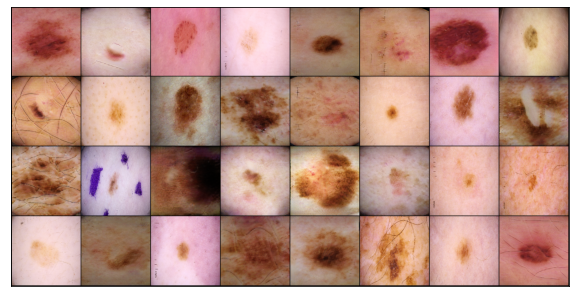

In [4]:
from torchvision.utils import make_grid

for images, labels in trainloader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    images = (images*0.5)+0.5
    ax.imshow(make_grid(images, 8).permute(1,2,0))
    break

In [5]:
class EfficientNet(nn.Module):
    def __init__(self):
        super(EfficientNet, self).__init__()
        self.base_model = efficientnet_pytorch.EfficientNet.from_pretrained('efficientnet-b4')
        self.base_model._fc = nn.Linear(in_features=1792, out_features=1, bias=True)
        
    def forward(self, image, targets):
        out = self.base_model(image)
        out = torch.sigmoid(out)
        loss = nn.BCELoss()(out, targets.view(-1, 1).type_as(out))
        return out, loss

In [6]:
model = EfficientNet()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=3,
        threshold=0.001,
        mode="max"
    )

In [8]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')
if cuda:
    model = model.cuda()
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

cuda: True


In [10]:
n_epochs = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(trainloader)
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(trainloader):
        data_, target_ = data_.type(Tensor), target_.type(Tensor)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        y_pred, loss = model(data_, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()        
        y_pred = (y_pred>0.5).float().squeeze(1)
        correct += torch.sum(y_pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validloader):
            data_t, target_t = data_t.type(Tensor), target_t.type(Tensor) # on GPU
            y_pred_t, loss_t = model(data_t, target_t)
            batch_loss += loss_t.item()
            y_pred_t = (y_pred_t>0.5).float().squeeze(1)
            correct_t += torch.sum(y_pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), './model_classification.pth')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/10], Step [0/1575], Loss: 0.3080
Epoch [1/10], Step [100/1575], Loss: 0.0268
Epoch [1/10], Step [200/1575], Loss: 0.1019
Epoch [1/10], Step [300/1575], Loss: 0.0057
Epoch [1/10], Step [400/1575], Loss: 0.0102
Epoch [1/10], Step [500/1575], Loss: 0.0069
Epoch [1/10], Step [600/1575], Loss: 0.0846
Epoch [1/10], Step [700/1575], Loss: 0.0526
Epoch [1/10], Step [800/1575], Loss: 0.0092
Epoch [1/10], Step [900/1575], Loss: 0.0111
Epoch [1/10], Step [1000/1575], Loss: 0.0151
Epoch [1/10], Step [1100/1575], Loss: 0.0558
Epoch [1/10], Step [1200/1575], Loss: 0.0122
Epoch [1/10], Step [1300/1575], Loss: 0.1070
Epoch [1/10], Step [1400/1575], Loss: 0.0024
Epoch [1/10], Step [1500/1575], Loss: 0.0122

train loss: 0.0457, train acc: 98.9504
validation loss: 0.0343, validation acc: 99.1507

Detected network improvement, saving current model
Epoch 2

Epoch [2/10], Step [0/1575], Loss: 0.0207
Epoch [2/10], Step [100/1575], Loss: 0.0083
Epoch [2/10], Step [200/1575], Loss: 0.0096
Epo